In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import math
import msprime
import numpy as np
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG


# Processing results

In the previous section we showed how to run simulations in msprime, and how to construct population models and demographic histories. In this section we show how to process the results of simulations. This is not a comprehensive review of the capabilities of the msprime Python API, but concentrates on some useful examples.

Msprime is specifically designed to enable very large simulations, and the processing methods be demonstrate below are all very efficient. To illustrate this we use a simulation of 200,000 samples of 10 megabases from a simple two-population model with human-like parameters:


In [2]:
%%time

ts = msprime.simulate(
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=10**5),
        msprime.PopulationConfiguration(sample_size=10**5)],
    demographic_events=[
        msprime.MassMigration(time=50000, source=1, destination=0)],
    Ne=10**4, recombination_rate=1e-8, mutation_rate=1e-8, length=10*10**6,
    random_seed=3)

CPU times: user 20.3 s, sys: 188 ms, total: 20.5 s
Wall time: 20.5 s


In [3]:
ts.num_trees, ts.num_sites

(93844, 102270)

## Computing MRCAs

We are often intested in finding the most recent common ancestor (MRCA) of a pair (or many pairs) of samples. For example, Identity-by-descent (IBD) tracts are defined as contiguous stretches of genome in which the MRCA for a pair of samples is the same. Computing IBD segments for a pair of samples is very straightforward:

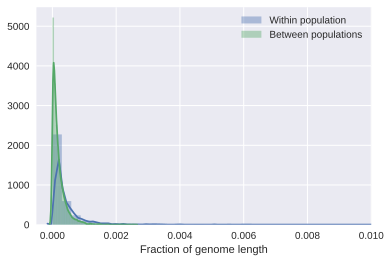

In [4]:
def ibd_segments(ts, a, b):
    trees_iter = ts.trees()
    tree = next(trees_iter)
    last_mrca = tree.mrca(a, b)
    last_left = 0
    segment_lengths = []
    for tree in trees_iter:       
        mrca = tree.mrca(a, b)
        if mrca != last_mrca:
            left = tree.interval[0]
            segment_lengths.append(left - last_left)
            last_mrca = mrca
            last_left = left
    segment_lengths.append(ts.sequence_length - last_left)
    return np.array(segment_lengths) / ts.sequence_length    

sns.distplot(ibd_segments(ts, 0, 1), label="Within population")
sns.distplot(ibd_segments(ts, 0, 10**5), label="Between populations")
plt.xlim(-0.0005, 0.01)
plt.legend()
plt.xlabel("Fraction of genome length");


In this example we create a function ``ibd_segments`` that returns a numpy array of the lengths of IBD segments for a given pair of samples, ``a`` and ``b``. It works simply by computing the MRCA for the samples at the left hand side of the sequence and then, moving rightwards, records a segment each time the MRCA changes. We then plot the distribution of tract lengths for samples 0 and 1 (which are both in the population 0), and also the tract lengths for a pair of samples from different populations. As we might expect, the tract lengths are shorter for the between population pair. 

Of course, we would need to sample many such pairs of samples to get a reasonable approximation of the real distribution of block lenghts. Because the main cost of this function is in iterating over all the trees in the sequence, it is more efficient to keep track of the MRCAs for different pairs while doing a single iteration than to repeatedly call the above ``ibd_segments`` function.


## Sample counts

The msprime API provides a very efficient way to count the number of samples that are beneath a particular node in a tree. This can be used, for example, to compute allele frequencies efficiently and is the basis for many of the fast algorithms in the API. As a simple illustration of this technique, consider the following code to compute the number of sites with derived allele frequency less than 1%:

In [5]:
N = ts.num_samples
threshold = 0.01
num_rare_derived = 0
for tree in ts.trees():
    for site in tree.sites():
        assert len(site.mutations) == 1
        mutation = site.mutations[0]
        if tree.num_samples(mutation.node) / N < threshold:
            num_rare_derived += 1
num_rare_derived, num_rare_derived / ts.num_sites   

(65258, 0.638095238095238)

In this example we iterate over all the trees in the tree sequence, and then iterate over all the sites in each tree. We then find the frequency of the derived allele at this site using the ``num_samples`` method, which returns the number of samples in the tree beneath a given node. The underlying implementation ensures that this operation requires constant time, and so it is *very* efficient. After the loop completes, we then see that such rare alleles are very common. (This code assumes that each site contains only a single mutation, which is always true for the simple infinite sites mutations currently output by msprime. However, it is possible to have more complex situations such as back and recurrent mutations in which this simplistic approach will not work.)

A very powerful feature of this sample-counting feature is that we can perform the same operation over an arbitrary subset of the samples. For example, suppose we wished to count the number of sites that are private to a specific population:

In [6]:
def num_private_sites(pop_id):
    pop_samples = ts.samples(pop_id)
    num_private = 0
    for tree in ts.trees(tracked_samples=pop_samples):
        for site in tree.sites():
            assert len(site.mutations) == 1
            mutation = site.mutations[0]
            total = tree.num_samples(mutation.node)
            within_pop = tree.num_tracked_samples(mutation.node)
            if total == within_pop:
                num_private += 1
    return num_private

private_0 = num_private_sites(0)
private_1 = num_private_sites(1)
ts.num_sites, private_0 + private_1, private_0, private_1 

(102270, 101607, 51295, 50312)

This example is very similar, except we provide an extra argument to ``ts.trees``. This ``tracked_samples`` argument is a list of samples that we are interested in tracking information about, and can be any arbitrary subset of the samples in the simulation. Here we indicate that we are interested in tracking the set of samples within the population in question. Again we iterate over all trees and over all sites within these trees. Then, for each infinite sites mutation we compute two frequencies: the overall number of samples that inherit from the mutation's node, and the number of samples *within the focal population* that inherit from this node. Then, if the total count is equal to within-population count, we know that this mutation is private to the population.

## Obtaining subsets

In some situations it is useful to analyse data for different subsets of the samples separately. This is possible using the ``simplify`` method:

In [7]:
samples = [1, 3, 5, 7]
ts_subset = ts.simplify(samples)
ts_subset.num_sites, ts_subset.num_trees, ts.num_sites, ts.num_trees

(11939, 5483, 102270, 93844)

Here we extract the tree sequence representing the history of a tiny subset of the original samples, with IDs 1, 3, 5 and 7. The subset tree sequence contains all the genealogical information relevant to these samples, but no more. Hence, coalescences that are not ancestral to the subsample are not included, and neither are coalescences that predate the MRCA of our subsample. Thus, the number of distinct trees is greatly reduced. By default, we also remove any sites that have no mutations within these subtrees (i.e., those that are fixed for the ancestral state). These can be retained by using the ``filter_zero_mutation_sites=False`` argument.

Node IDs in the simplified tree sequence are not the same as in the original. The ``map_nodes`` argument allows us to obtain the mapping from IDs in the original tree sequence to their equivalant nodes in the new tree sequence. 

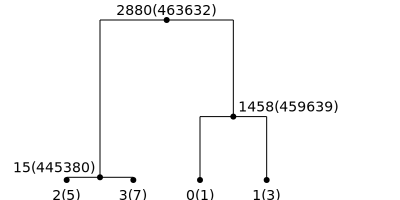

In [15]:
ts_subset, node_map = ts.simplify(samples, map_nodes=True)
tree = ts_subset.first()
node_labels = {
    node_map[j]: "{}({})".format(node_map[j], str(j)) for j in range(ts.num_nodes)}
SVG(tree.draw(node_labels=node_labels, width=400))

Here we plot the first tree in the subset tree sequence, showing the new node IDs along with the IDs from the original tree sequence in parantheses.

## Processing variants

While it is nearly always more efficient to work with mutations in terms of their context within the trees, it is sometimes more convenient to work with the allelic states of the samples. This information is obtained in msprime using the ``variants()`` iterator, which returns a ``Variant`` object for each site in the tree sequence. A ``Variant`` consists of: (a) a reference to the site in question; (b) the ``alleles`` at this site (the strings representing the actual states); and (c) the ``genotypes`` representing the observed state for each sample. The ``genotypes`` are encoded in a numpy array, such that ``variant.alleles[variant.genotypes[j]]`` gives the allelic state for sample ID ``j``. The values in the ``genotypes`` array are therefore indexes into the ``alleles`` list. The ancestral state at a given site is guaranteed to be the first element in the ``alleles`` list, but no other assumptions about ordering of the alleles list should be made.

For biallelic sites, working with genotypes is straightforward as the genotypes array can only contain 0 and 1 values, and these correspond to the ancestral and derived states, respectively. The ``genotypes`` values are returned as a numpy array, and so the full numpy library is available for efficient processing. As an example, we show here how to count the number of sites at which the derived allele is at frequency less than 10%. Using the  genotypes in this way is convenient, as complex patterns of back and recurrent mutations can be handled without difficulty. Note, however, that it is much less efficient, taking about 50 times longer than the equivalent tree-based code (below) in this case.

In [16]:
%%time
threshold = 0.1
num_rare = 0
for variant in ts.variants():
    # Will work for any biallelic sites; back/recurrent mutations are fine.
    assert len(variant.alleles) == 2
    if np.sum(variant.genotypes) / ts.num_samples < threshold:
        num_rare += 1
print(num_rare)

83081
CPU times: user 1min 30s, sys: 4 ms, total: 1min 30s
Wall time: 1min 30s


In [10]:
%%time
threshold = 0.1
num_rare = 0
for tree in ts.trees():
    for site in tree.sites():
        # Only works for simple infinites sites mutations.
        assert len(site.mutations) == 1
        mutation = site.mutations[0]
        if tree.num_samples(mutation.node) / ts.num_samples < threshold:
            num_rare += 1
print(num_rare)

83081
CPU times: user 1.75 s, sys: 36 ms, total: 1.79 s
Wall time: 1.79 s


## Incremental calculations

A powerful property of the tree sequence representation is that we can efficiently find the differences between adjacent trees. This is very useful when we have some value that we wish to compute that changes in a simple way between trees. The ``edge_diffs`` iterator provides us with the information that we need to perform such incremental calculations. Here we use it to keep a running track of the total branch length of our trees, without needing to perform a full traversal each time.

In [11]:
def get_total_branch_length(ts):
    current = 0
    total_branch_length = np.zeros(ts.num_trees)
    for index, (_, edges_out, edges_in) in enumerate(ts.edge_diffs()):
        for edge in edges_out:
            current -= ts.node(edge.parent).time - ts.node(edge.child).time
        for edge in edges_in:
            current += ts.node(edge.parent).time - ts.node(edge.child).time
        total_branch_length[index] = current
    return total_branch_length

This function returns the total branch length value for each tree in the sequence as a numpy array. It works by keeping track of the total branch length as we proceed from left to right, and storing this value in the output array for each tree. The ``edge_diffs`` method returns a list of the edges that are removed for each tree transition (``edges_out``) and a list of edges that are inserted (``edges_in``). Computing the current value for the total branch length is then simply a case of subtracting the branch lengths for all outgoing edges and adding the branch lengths for all incoming edges. This is extremely efficient because, after the first tree has been constructed there is at most four incoming and outgoing edges. Thus, each tree transition costs *constant time*.

On the other hand, if we compute the total branch length by performing a full traversal for each tree, each tree transition is very costly for large trees. In this example, computing the array of branch lengths using the incremental approach given here took 8 seconds. Computing the same array using the ``tree.total_branch_length`` for each tree in a straightforward way still had not completed after *twenty minutes*. (This is because msprime currently implements this operation by a full traversal in Python; in future this may change to using the algorithm given here.) Full tree traversals of large trees are expensive, and great gains can be made if calculations can be expressed in an incremental manner using ``edge_diffs``.

In [18]:
%%time
tbl = get_total_branch_length(ts)

CPU times: user 7.67 s, sys: 64 ms, total: 7.74 s
Wall time: 7.75 s


In [13]:
#%%time
# Took > 20 minutes before getting bored.
# tbl2 = np.array([tree.total_branch_length for tree in ts.trees()])

## Exporting variant data

If the msprime API doesn't provide methods to easily calculate the statistics you are interested in, it's straightforward to export the variant data into other libraries using the ``genotype_matrix()`` or ``variants()`` methods. We recommmend the excellent scikit-allel (REF) and libsequence (REF) libraries. If you wish to export data to external programs, VCF may be best option, which is supported using the ``write_vcf`` method. The ``simplify`` method is useful here is you wish to export data from a subset of the simulated samples.

However, it is worth noting that for large sample sizes, exporting genotype data may require a great deal of memory and take some time. One of the advantages of the msprime API is that we do not need to explicitly generate genotypes in order to compute many interesting statistics.